In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
        'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift

##from csr2d.csr_kick import calc_csr_kick  ##Obsolete
from csr2d.kick import csr2d_kick_calc
import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

# Beam and parameters definition

In [ ]:
!pwd

In [17]:
P = ParticleGroup('bmad/Beam_in.h5')

Np = len(P.x)   # number of macro-particles

E0 = 30 * 1e9 
gamma = E0 /mec2
beta = (1-1/gamma**2)**(1/2)
p0c = gamma * beta * mec2  # in eV

beam, charges = particle_group_to_bmad(P, p0c = p0c)

Q = P.charge
Nb = Q/e_charge

LB = 20
rho = LB/0.013   # LB / angle from lattice

sigma_z = np.std(beam[4])

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * mec2 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

In [18]:
W0

98649.33856757519

In [5]:
# Check beam optics
P.twiss()

{'alpha_x': 11.82910831473418,
 'beta_x': 2114.8897505455247,
 'gamma_x': 0.06663600477772504,
 'emit_x': 8.513877104839212e-12,
 'eta_x': 7.648952581091348e-05,
 'etap_x': -4.248274262044829e-07,
 'norm_emit_x': 4.998353955908784e-07}

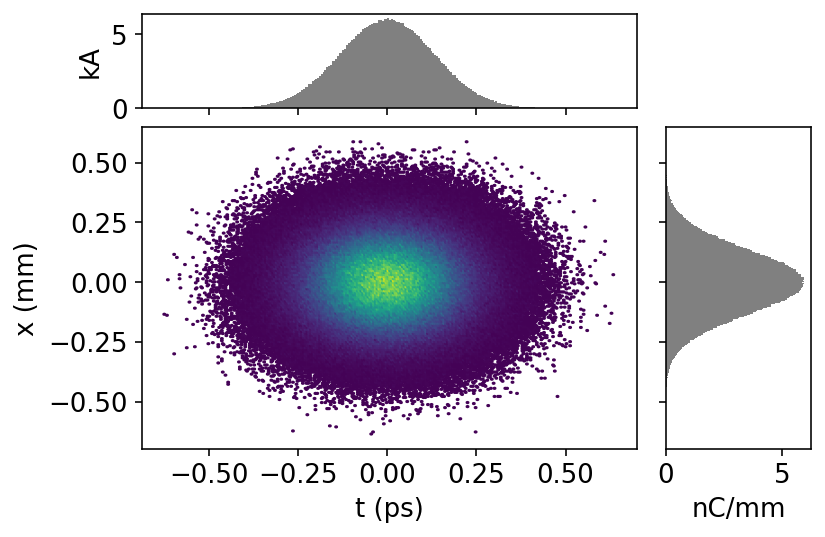

In [63]:
P.plot('t', 'x', bins=250)

In [64]:
# Save the initial beam to run in Bmad
#P.write_bmad('Glen_beam_Np1M.txt',p0c = P0c, t_ref = 0)

In [4]:
# Yunhai's theory assumes rho to be always positive, and particles with positive x-value are on the outer side of a bend. 
# When the bending angle is negative (i.e. particles with positive x-value is on the inner side of a bend),
# flip the beam in x before and after the CSR calculation and kick, the apply -xp kick

# Higher level routine

In [19]:
def track_bend_with_2d_csr(Pin, p0c=None, gamma=None, L=0, g=0, g_err=0, N_step=20, s0=0, nz=200, nx=200, xlim=None, zlim=None,
                           map_f=map, CSR_on = True, energy_kick_on=True, xp_kick_on=True, bend_name='the bend', 
                           keep_Pin=True, debug=True, save_all_P=False, h5_save=None):

    Plist = []       # To save the beam at each step
    csr_data_list = []  # To save the wake and grid at each step
    slist = []      # To save the s position at each step
    s = s0
    
    if (keep_Pin):
        Plist.append(Pin)
        slist.append(s0)
    
    rho = 1/g    # rho can be negative     

    beam, charges = particle_group_to_bmad(Pin, p0c = p0c)
    
    #N_steps = int(np.floor(L/ds_step))
    ds_step = L/N_step

    for i in range(N_step):
        print('Tracking through', bend_name, 'in the', i+1 , "th step starting at s=" , s,'m' ) 

        ## track through a bend of length ds/2
        beam = track_a_bend(beam, p0c = p0c, L=ds_step/2, theta = ds_step/2/rho, g_err=g_err)
    
        ## Calculate CSR kicks to xp and delta
        ####===================================
    
        if (CSR_on):
  
            #with cf.ProcessPoolExecutor(max_workers=12) as executor:
            csr_data = csr2d_kick_calc(beam[4,:], beam[0,:], charges, gamma=gamma, rho=rho, nz=nz, nx=nx, zlim=zlim, xlim=xlim,
                                     map_f = map_f, debug=debug)
                
            csr_data_list.append(csr_data)
                  
            #output = calc_csr_kick(beam, charges, Np=Np, gamma = 10000, rho = rho, Nz=100, sigma_z=sigma_z, Nx=100, sigma_x=sigma_x, verbose=True)
            
            if (energy_kick_on):
                print('Applying energy kick...')
                delta_kick = csr_data['ddelta_ds'] 
                #print('avg delta_kick:', np.mean(delta_kick), 'ds_step', ds_step)
                #print('max delta_kick:', np.max(delta_kick), 'ds_step', ds_step)
                #print('min delta_kick:', np.min(delta_kick), 'ds_step', ds_step)
                beam[5] = beam[5] + delta_kick * ds_step
            
            if (xp_kick_on):
                print('Applying xp_kick...')
                xp_kick = csr_data['dxp_ds'] 
                beam[1] = beam[1] + xp_kick * ds_step
    
        ####====================================

        ## track through a bend of length ds/2
        beam = track_a_bend(beam, p0c = p0c, L=ds_step/2, theta = ds_step/2/rho, g_err=g_err)
    
        s += ds_step
    
        # save the beam and s at every step into a h5 file
        if h5_save:
            print('Saving beam into the h5 file...')
            P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
            g = h5_save.create_group(bend_name + str(i))
            P.write(g)
    
        # save the beam and s at every step
        if save_all_P:
            #P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
            #Plist.append(P)
            slist.append(s)
    
    output = {}
    output['Pout'] = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
    if save_all_P:
        #output['csr_data_list'] = csr_data_list
        #output['Plist'] = Plist
        output['slist'] = slist

    return output

In [20]:
def track_drift_with_2d_csr(Pin, p0c=None, gamma=None, L=0, N_step=20, s0=0, drift_name ='the drift', 
                            keep_Pin=True, debug=True, save_all_P=False, h5_save=None):

    Plist = []       # To save the beam at each step
    slist = []      # To save the s position at each step
    s = s0

    if (keep_Pin):
        Plist.append(Pin)
        slist.append(s0)
    
    beam, charges = particle_group_to_bmad(Pin, p0c = p0c)
    
    #N_steps = int(np.floor(L/ds_step))
    ds_step = L/N_step

    for i in range(N_step):
        #print('Tracking through', drift_name, 'in the', i+1 , "th step starting at s=" , s,'m' ) 

        ## track through a drift of length ds_step
        beam = track_a_drift(beam, p0c, L=ds_step)
    
        s += ds_step
        
        # save the beam and s at every step into a h5 file
        if h5_save:
            print('Saving beam into the h5 file...')
            P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
            g = h5_save.create_group(drift_name + str(i))
            P.write(g)
            
        # save the beam and s at every step
        if save_all_P:
            #P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
            #Plist.append(P)
            slist.append(s)
    
    output = {}
    output['Pout'] = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
    if save_all_P:
        #output['Plist'] = Plist
        output['slist'] = slist

    return output
    

In [21]:
#def track_drift_with_2d_csr(Pin, p0c=None, gamma=None, L=0, N_step=20, s0=0, drift_name ='the drift', keep_Pin=True, debug=True):
#def track_bend_with_2d_csr(Pin, p0c=None, gamma=None, L=0, g=0, g_err=0, N_step=20, s0=0, nz=500, nx=500, 
#                                     map_f=map, CSR_on = True, xp_kick_on=True, bend_name='the bend', keep_Pin=True, debug=True):
    
    
def track_chicane_with_2d_csr(Pin, p0c=None, gamma=None, L_bend=0, g=0, g_err=0, N_step_bend=20, s0=0, nz=200, nx=200, 
                              map_f=map, CSR_on = True, energy_kick_on=True, xp_kick_on=True,
                              L_drift=0, N_step_drift=20, keep_Pin=True, debug=True, save_all_P=False, h5_save=None):
    print(Pin.charge)
    
    print('Begin tracking through BEND #1...')
    out1 = track_bend_with_2d_csr(Pin, p0c=p0c, gamma=gamma, L=L_bend, g=g, g_err=g_err, N_step=N_step_bend, s0=s0, nz=nz, nx=nx, 
                                  map_f=map_f, CSR_on=CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on,
                                  bend_name='B1', keep_Pin=keep_Pin, debug=debug, save_all_P=save_all_P, h5_save=h5_save)
    
    print('Begin tracking through DRIFT #1...')
    s=s0+L_bend
    out2 = track_drift_with_2d_csr(out1['Pout'], p0c=p0c, gamma=gamma, L=L_drift, N_step=N_step_drift, s0=s, 
                                   drift_name ='D1', keep_Pin=False, debug=debug, save_all_P=save_all_P, h5_save=h5_save)

    print('Begin tracking through BEND #2...')
    s=s+L_drift
    out3 = track_bend_with_2d_csr(out2['Pout'], p0c=p0c, gamma=gamma, L=L_bend, g=-g, g_err=g_err, N_step=N_step_bend, s0=s, nz=nz, nx=nx, 
                                  map_f=map_f, CSR_on = CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on,
                                  bend_name='B2', keep_Pin=False, debug=debug, save_all_P=save_all_P, h5_save=h5_save)
    
    print('Begin tracking through DRIFT #2...')
    s=s+L_bend
    out4 = track_drift_with_2d_csr(out3['Pout'], p0c=p0c, gamma=gamma, L=L_drift, N_step=N_step_drift, s0=s, 
                                    drift_name ='D2', keep_Pin=False, debug=debug, save_all_P=save_all_P, h5_save=h5_save)
 
    print('Begin tracking through BEND #3...')
    s=s+L_drift
    out5 = track_bend_with_2d_csr(out4['Pout'], p0c=p0c, gamma=gamma, L=L_bend, g=-g, g_err=g_err, N_step=N_step_bend, s0=s, nz=nz, nx=nx, 
                                  map_f=map_f, CSR_on = CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on,
                                  bend_name='B3', keep_Pin=False, debug=debug, save_all_P=save_all_P, h5_save=h5_save)
    
    print('Begin tracking through DRIFT #3...')
    s=s+L_bend
    out6 = track_drift_with_2d_csr(out5['Pout'], p0c=p0c, gamma=gamma, L=L_drift, N_step=N_step_drift, s0=s, 
                                     drift_name ='D3', keep_Pin=False, debug=debug, save_all_P=save_all_P, h5_save=h5_save)
    
    print('Begin tracking through BEND #4...')
    s=s+L_drift
    out7 = track_bend_with_2d_csr(out6['Pout'], p0c=p0c, gamma=gamma, L=L_bend, g=g, g_err=g_err, N_step=N_step_bend, s0=s, nz=nz, nx=nx, 
                                  map_f=map_f, CSR_on = CSR_on, energy_kick_on=energy_kick_on, xp_kick_on=xp_kick_on,
                                  bend_name='B4', keep_Pin=False, debug=debug, save_all_P=save_all_P, h5_save=h5_save)    
    
    print('Tracking finished!!!')


    output = {}
    output['Pout_B1'] = out1['Pout'] 
    output['Pout_D1'] = out2['Pout'] 
    output['Pout_B2'] = out3['Pout']  
    output['Pout_D2'] = out4['Pout'] 
    output['Pout_B3'] = out5['Pout'] 
    output['Pout_D3'] = out6['Pout'] 
    output['Pout_B4'] = out7['Pout']  
    
    if save_all_P:
        slist = out1['slist'] + out2['slist'] + out3['slist'] + out4['slist'] + out5['slist'] + out6['slist'] + out7['slist']
        #Plist = out1['Plist'] + out2['Plist'] + out3['Plist'] + out4['Plist'] + out5['Plist'] + out6['Plist'] + out7['Plist']
        #output['Plist'] = Plist
        output['slist'] = slist

    return output

# Testing

In [7]:
beam, charges = particle_group_to_bmad(P, p0c = p0c)

In [71]:
np.max(beam[0])

0.0005869464537231999

In [72]:
np.min(beam[0])

-0.0006357888411234348

In [73]:
np.std(beam[0])*6

0.0008051171031175292

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from csr2d.core import alpha, alpha_where_z_not_zero, alpha_exact

In [23]:
0.9999999999* np.array(xv.shape)

array([99.99999999])

In [33]:
xv = np.linspace(-1e-8,1e-8, 100)
#zz = 0* np.ones(xv.shape)
zz = 0
beta = 0.9999999999* np.ones(xv.shape)


plt.plot(xv,alpha(zz,xv,beta),c='b',label='current')
#plt.scatter(xv,alpha_where_z_not_zero(zz,xv,beta),c='red',s=12, label='old')
plt.scatter(xv,alpha_exact(zz,xv,beta),c='g',s=12, label='exact')
plt.legend()

TypeError: 'int' object is not subscriptable

In [13]:
ob['csr_data_list'][0]['zvec2'][198:202]

array([-3.80151704e-06, -1.90075852e-06,  0.00000000e+00,  1.90075852e-06])

In [17]:
from csr2d.core import psi_s, psi_x
nz = 200
nx = 200
dz = 1e-20
dx = 1e-20

In [18]:
zvec2 = np.arange(-nz,nz,1)*dz # center = 0 is at [nz]
xvec2 = np.arange(-nx,nx,1)*dx # center = 0 is at [nx]
zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")

beta_grid = beta * np.ones(zm2.shape)

# Map (possibly parallel)
temp = map(psi_x, zm2 / 2 / rho, xm2 / rho, beta_grid)
psi_x_grid = np.array(list(temp))

In [6]:
#factor = 8
#xlim =[-np.std(beam[0])*factor, np.std(beam[0])*factor]
#zlim =[-np.std(beam[4])*factor, np.std(beam[4])*factor]  

xlim=None
zlim=None

ob = track_bend_with_2d_csr(P, p0c=p0c, gamma=gamma, L=0.001, g=1/rho, g_err=0, N_step=1, s0=0, nz=200, nx=200, xlim=xlim, zlim=zlim, 
                                    map_f=map, CSR_on = True, energy_kick_on=False, xp_kick_on=True,
                               bend_name='the bend', keep_Pin=True, debug=True, save_all_P=True)

Tracking through the bend in the 1 th step starting at s= 0 m
Depositing particles takes: 0.49556779861450195 s
Computing potential grids take: 2.598520040512085 s
Convolution takes: 0.05807209014892578 s
Applying xp_kick...


In [ ]:
# Full chicane tracking, might take long time

#h5 = h5py.File('test.h5','w')

with cf.ProcessPoolExecutor(max_workers=20) as executor:
    ooo = track_chicane_with_2d_csr(P, p0c=p0c, gamma=gamma, L_bend=20, g=1/rho, g_err=0, N_step_bend=50, s0=0, nz=100, nx=100, 
                              map_f=executor.map, CSR_on = True, energy_kick_on=True, xp_kick_on=True,
                              L_drift=32.5, N_step_drift=10, keep_Pin=False, debug=False, save_all_P=True, h5_save=False)
    
#h5.close()

2.0000000163547774e-09
Begin tracking through BEND #1...
Tracking through B1 in the 1 th step starting at s= 0 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 2 th step starting at s= 0.4 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 3 th step starting at s= 0.8 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 4 th step starting at s= 1.2000000000000002 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 5 th step starting at s= 1.6 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 6 th step starting at s= 2.0 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 7 th step starting at s= 2.4 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 8 th step starting at s= 2.8 m
Applying energy kick...
Applying xp_kick...
Tracking through B1 in the 9 th step starting at s= 3.1999999999999997 m
Applying energy kick...
Applying xp_kick.

## analysis

Text(0.5, 1.0, 'CSR longitudinal kick along x=0\n (chicane, s=0)')

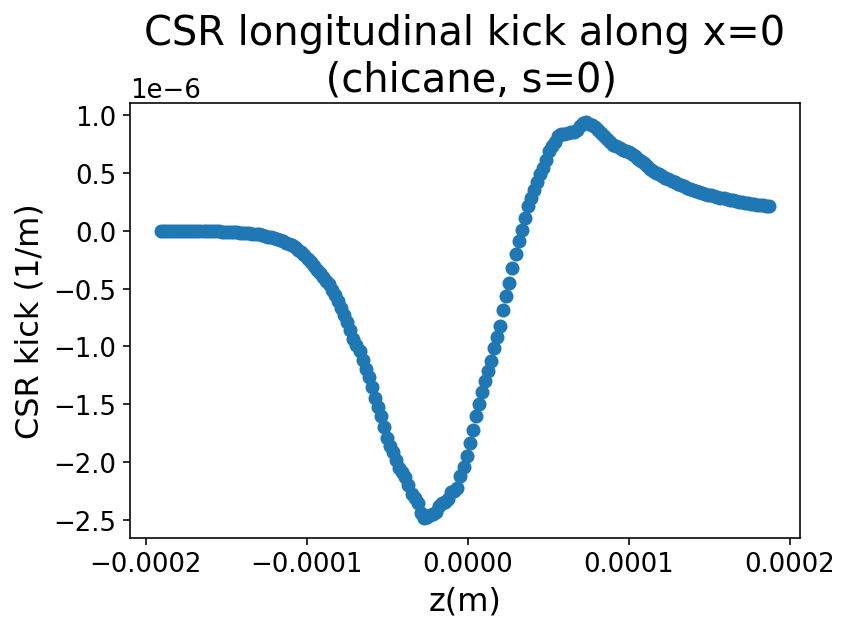

In [97]:
zv = ob['csr_data_list'][0]['zvec']
xv = ob['csr_data_list'][0]['xvec']
Ws_grid = ob['csr_data_list'][0]['Ws_grid']
kick_factor = r_e*Q/e_charge/gamma

#*p0c/W0

plt.scatter(zv, Ws_grid[:,100]*kick_factor)
plt.xlabel('z(m)', fontsize=16)
plt.ylabel('CSR kick (1/m)', fontsize=16)
plt.title('CSR longitudinal kick along x=0\n (chicane, s=0)',  fontsize=20)
#plt.legend()

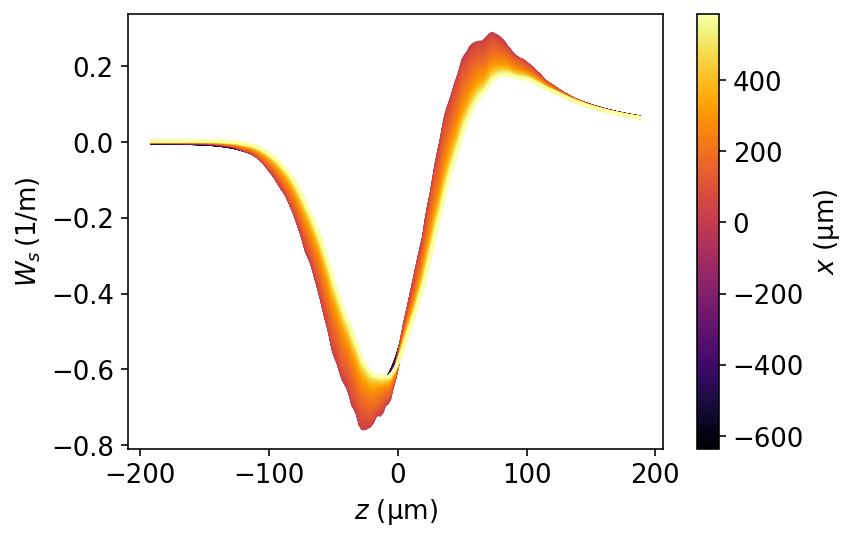

In [67]:
W=Ws_grid.T *kick_factor*p0c/W0
zvec = zv *1e6

cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(np.linspace(0,1,len(W)))
fig, ax = plt.subplots(figsize=(6,4))
for i, ws in enumerate(W):
    ax.plot(zvec, ws, color=colors[i])
    
xvec = xv *1e6
xmin = min(xvec) 
xmax = max(xvec)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=xmin, vmax=xmax))
cbar = fig.colorbar(sm)  

cbar.set_label('$x$'+' (µm)')
#ax.set_title('2D CSR wake')
ax.set_xlabel('$z$'+' (µm)')
ax.set_ylabel(r'$W_s\, (1/\mathrm{m})$')
plt.savefig('Ws.png', dpi=150)

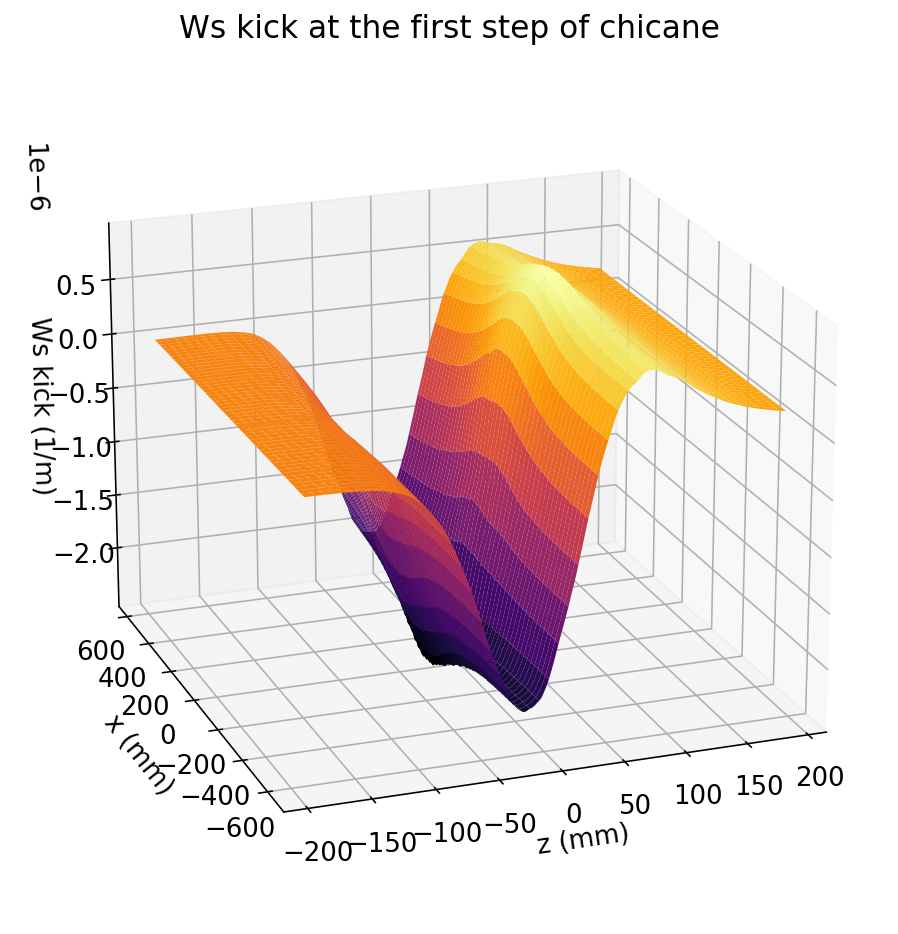

In [69]:
#psi_s_grid=ob['csr_data_list'][0]['psi_s_grid']
zv = ob['csr_data_list'][0]['zvec']*1e6
xv = ob['csr_data_list'][0]['xvec']*1e6

from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zv, xv,indexing='ij')

fig, ax = plt.subplots(figsize=(8,8))

ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Ws_grid*kick_factor , cmap='inferno')
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('Ws kick (1/m)')
ax.set_title('Ws kick at the first step of chicane')

ax.view_init(20, 250)

In [75]:
Ws_glen.shape

(100, 100)

In [103]:
zv_glen = np.loadtxt('./Glen_matlab_results/2data_bend1/Z.txt')
xv_glen = np.loadtxt('./Glen_matlab_results/2data_bend1/X.txt')
Ws_glen_raw = np.loadtxt('./Glen_matlab_results/2data_bend1/Ws.txt')
Ws_glen = np.nan_to_num(Ws_glen_raw[1:101].T)

In [102]:
Ws_glen_raw.shape

(101, 100)

In [120]:
Ws_grid[0][0].__class__

numpy.float64

In [121]:
Ws_glen[0][0].__class__

numpy.float64

In [95]:
Ws_glen.shape

(100, 100)

In [109]:
zv_glen[50]

8.7984584e-07

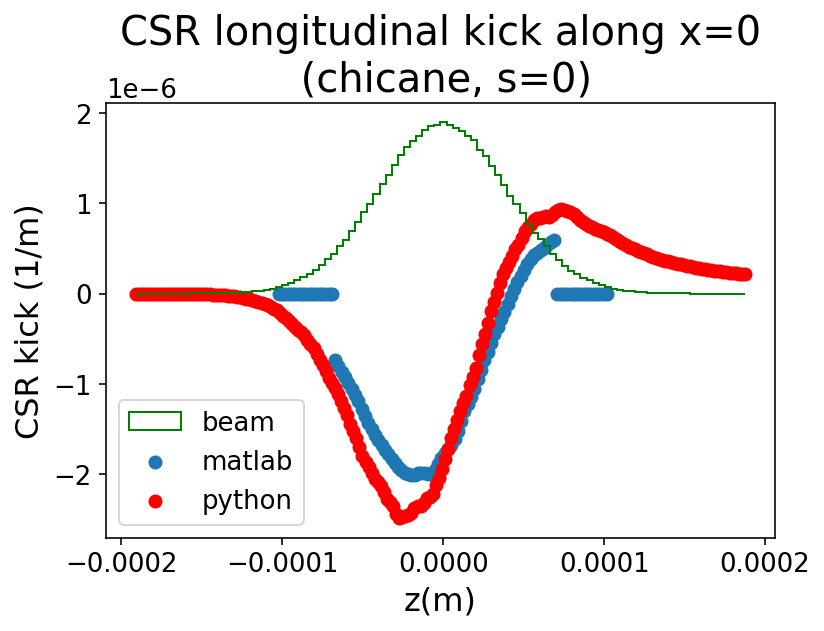

In [180]:

plt.scatter(zv_glen, Ws_glen[:,50],label='matlab')

plt.scatter(zv, Ws_grid[:,100]*kick_factor,c='r',label='python')

weights = np.ones_like(beam[4])/float(len(beam[4]))/2e4   #normalization
plt.hist(beam[4],bins=100,histtype='step',weights=weights,color='g',label='beam')

plt.xlabel('z(m)', fontsize=16)
plt.ylabel('CSR kick (1/m)', fontsize=16)
plt.title('CSR longitudinal kick along x=0\n (chicane, s=0)',  fontsize=20)
plt.legend()

In [145]:
Ws_glen[84,50] ==0

True

In [148]:
zv_glen[16]

-6.9166117e-05

In [153]:
zv_glen[84]

7.0925808e-05

In [151]:
41627/1e6

0.041627

In [150]:
np.count_nonzero(beam[4] < -6.9166117e-05)

41627

In [154]:
np.count_nonzero(beam[4] > 7.0925808e-05)

38057

In [178]:
(41627+38057)/1e6

0.079684

In [181]:
zv_glen[0]

-0.00010212892

In [182]:
zv_glen[-1]

0.00010182844

In [183]:
np.std(beam[4])

3.998430936730773e-05

ValueError: shape mismatch: objects cannot be broadcast to a single shape

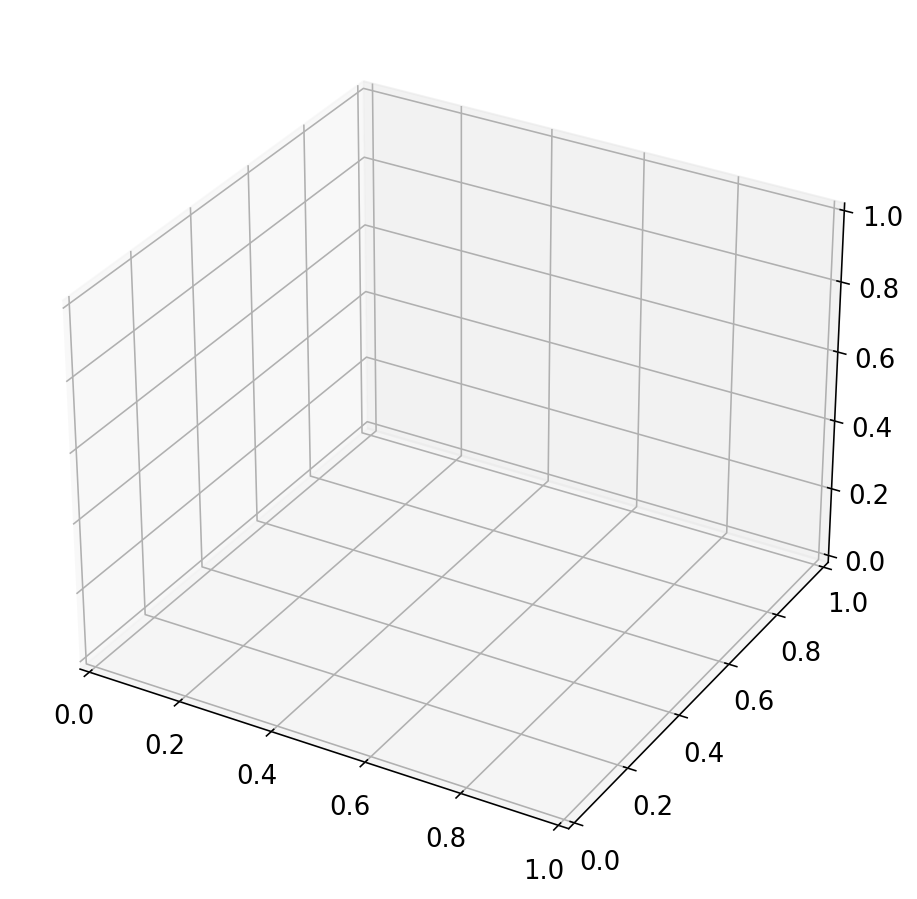

In [99]:
#psi_s_grid=ob['csr_data_list'][0]['psi_s_grid']
#zv_glen = ob['csr_data_list'][0]['zvec']*1e6
#xv_glen = ob['csr_data_list'][0]['xvec']*1e6

Z, X = np.meshgrid(zv_glen, xv_glen, indexing='ij')

fig, ax = plt.subplots(figsize=(8,8))

ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Ws_glen , cmap='inferno')
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('Ws kick (1/m)')
ax.set_title('Ws kick at the first step of chicane')

ax.view_init(20, 260)

In [59]:
xv.shape

(100,)

In [35]:
np.max(xv)

586.9448026846719

In [34]:
np.min(beam[4]) *1e6

-190.79715597028266

Text(0.5, 0.92, 'psi_s at the first step of chicane')

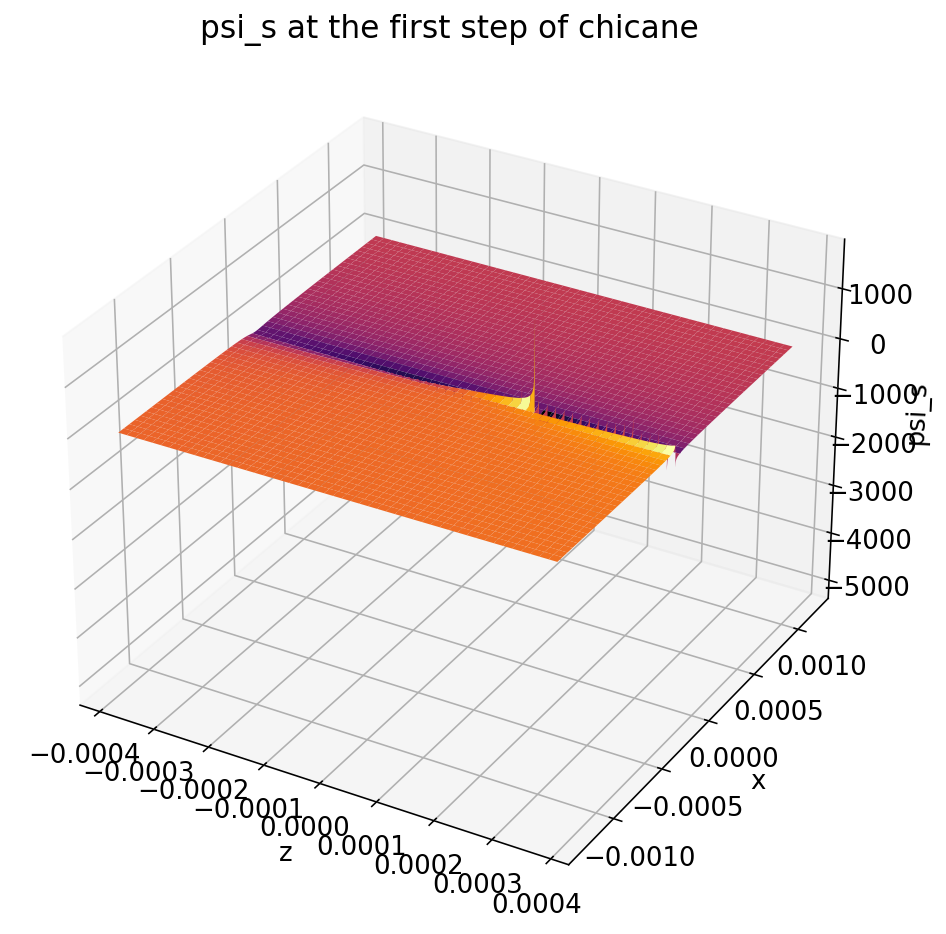

In [35]:
psi_s_grid=ob['csr_data_list'][0]['psi_s_grid']
zv2 = ob['csr_data_list'][0]['zvec2']
xv2 = ob['csr_data_list'][0]['xvec2']

from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zv2, xv2)

fig, ax = plt.subplots(figsize=(8,8))

ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, psi_s_grid , cmap='inferno')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [264]:
(min(P.p) -p0c)/p0c

-0.012044459836443065

In [8]:
# Extracting data from all P takes time!!

from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File

dat_list = []

#filename = './bmad/beam_dump_csroff_Np1M.h5'
filename = './chicane_both_kicks_on.h5'
with File(filename, 'r') as h5:
    ppaths = list(h5)
    
    for g in ppaths:
        P = ParticleGroup(h5[g])
        dat = get_data(P)
        dat_list.append(dat)

In [4]:
?ParticleGroup.twiss

Object `ParticleGroup.twiss` not found.


In [11]:
len(dat_list)

230

In [10]:
slist = ooo['slist']
Plist = ooo['Plist']

SyntaxError: unmatched ')' (<ipython-input-10-30f2677e8e96>, line 2)

In [5]:
def get_data(P):
 
    out = P.twiss('xy')  # already a dictionary
  
    out['sigma_x'] = P['sigma_x'] 
    out['sigma_p'] = P['sigma_p'] 
    out['sigma_z'] = P['sigma_t'] *c_light
    return out

In [11]:
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]

beta_x_list = [P.twiss()['beta_x'] for P in Plist]
#alpha_x_list = [P.twiss()['alpha_x'] for P in Plist]
eta_x_list = [P.twiss()['eta_x'] for P in Plist]
beamsize_x_list = [P['sigma_x'] for P in Plist]
sigma_p_list = [P['sigma_p'] for P in Plist]
sigma_z_list = [P['sigma_t']*c_light for P in Plist]

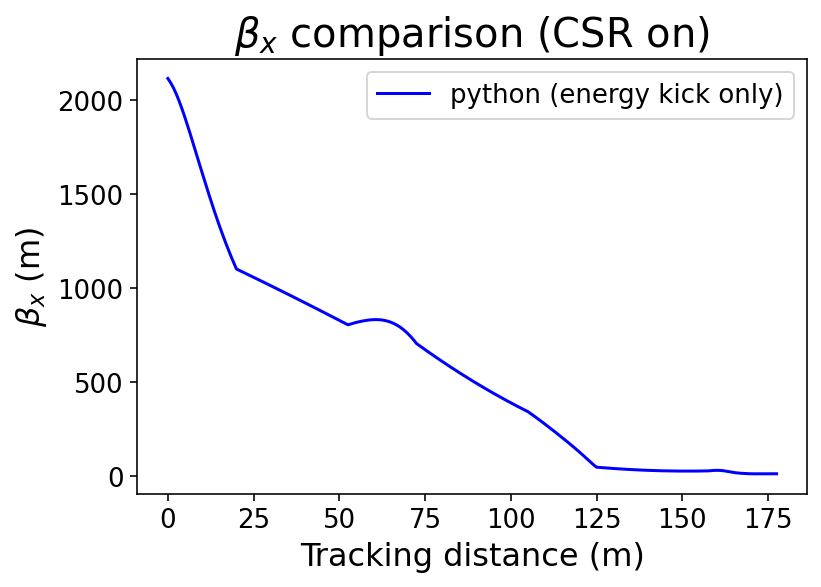

In [12]:
plt.plot(slist, beta_x_list, label = 'python (energy kick only)',color='b')
#plt.scatter(slist, tao_beta_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
#plt.scatter(slist, eleg_beta_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\beta_x$ (m)', fontsize=16)
plt.title(r'$\beta_x$ comparison (CSR on)', fontsize=20)
plt.legend();

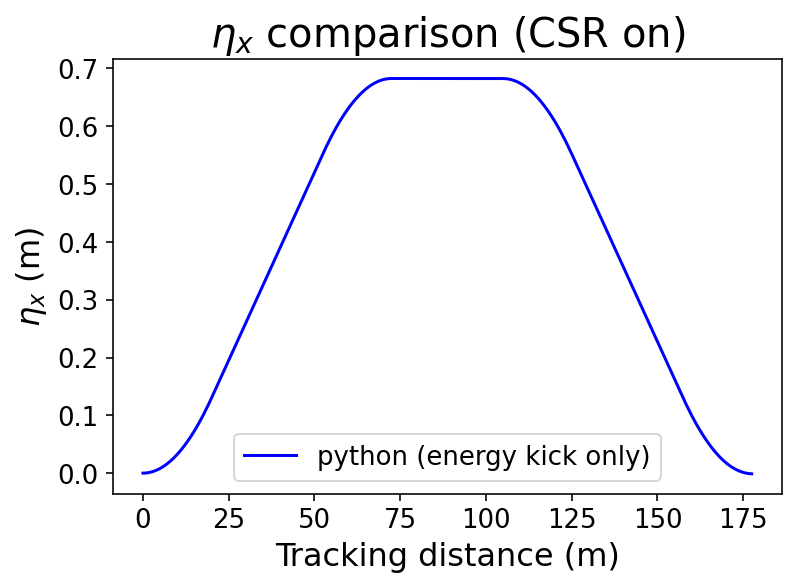

In [13]:
plt.plot(slist, eta_x_list, label = 'python (energy kick only)', color='b')
#plt.scatter(slist, tao_eta_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
#plt.scatter(slist, eleg_eta_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\eta_x$ (m)', fontsize=16)
plt.title(r'$\eta_x$ comparison (CSR on)', fontsize=20)
plt.legend();

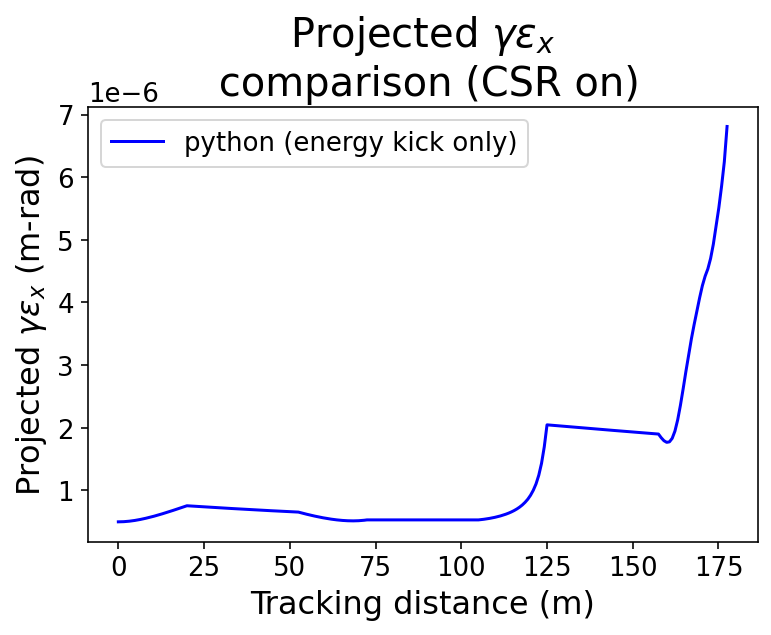

In [14]:
plt.plot(slist, pro_emit_x_list, label = 'python (energy kick only)',color='b')
#plt.scatter(slist, tao_pro_emit_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
#plt.scatter(slist, eleg_pro_emit_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)
#plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (energy kick only)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend();

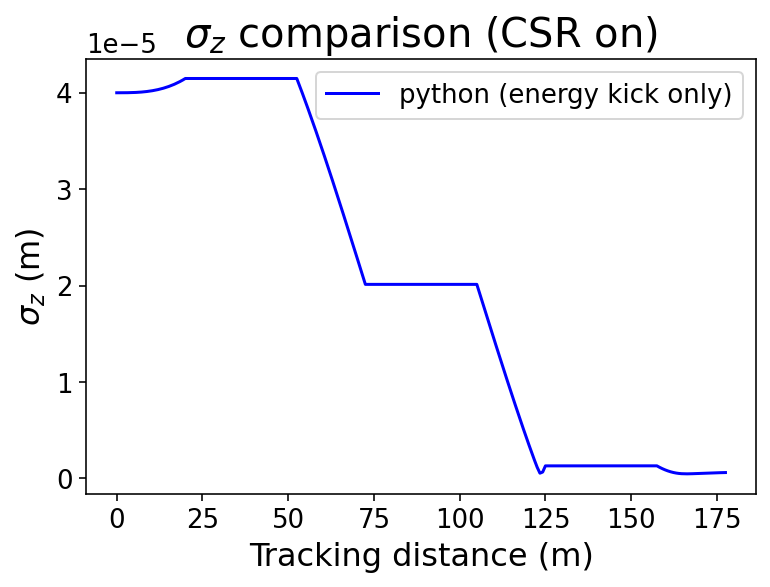

In [15]:
plt.plot(slist, sigma_z_list, label = 'python (energy kick only)',color='b')
#plt.scatter(slist, tao_beamsize_x_list, label = 'bmad (1D CSR)',color='r',marker = '.')
#plt.scatter(slist, eleg_beamsize_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\sigma_z$ (m)', fontsize=16)
plt.title('$\sigma_z$ comparison (CSR on)', fontsize=20)
plt.legend()

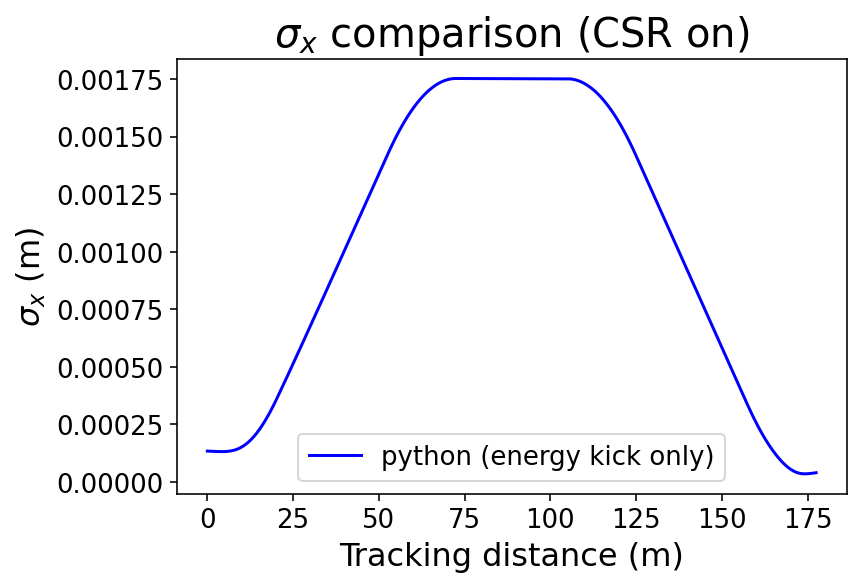

In [16]:
plt.plot(slist, beamsize_x_list, label = 'python (energy kick only)',color='b')
#plt.scatter(slist, tao_beamsize_x_list, label = 'bmad',color='r',marker = '.')
#plt.scatter(slist, eleg_beamsize_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('$\sigma_x$ (m)', fontsize=16)
plt.title('$\sigma_x$ comparison (CSR on)', fontsize=20)
plt.legend()

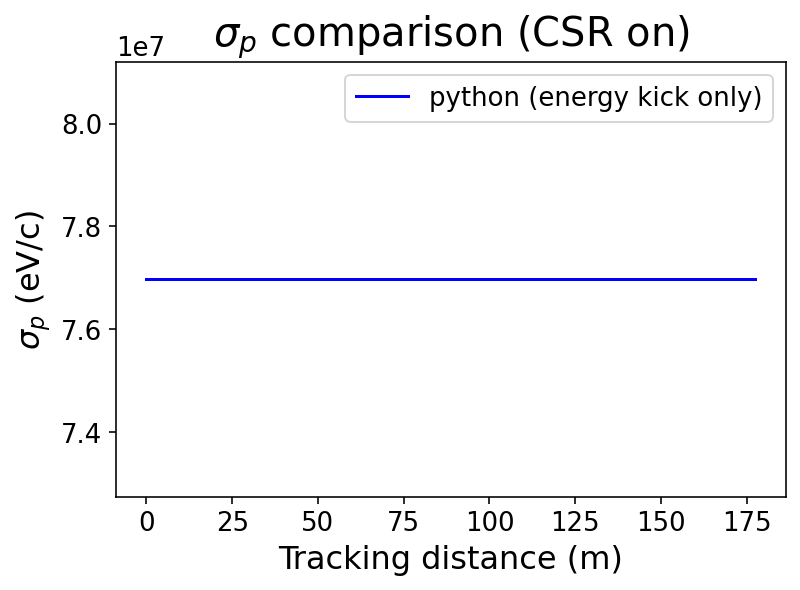

In [17]:
plt.plot(slist, sigma_p_list, label = 'python (energy kick only)',color='b')
#plt.scatter(slist, tao_sigma_p_list, label = 'bmad',color='r',marker = '.')
#plt.scatter(slist, eleg_sigma_p_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('$\sigma_{p}$ (eV/c)', fontsize=16)
plt.title('$\sigma_{p}$ comparison (CSR on)', fontsize=20)
plt.legend()

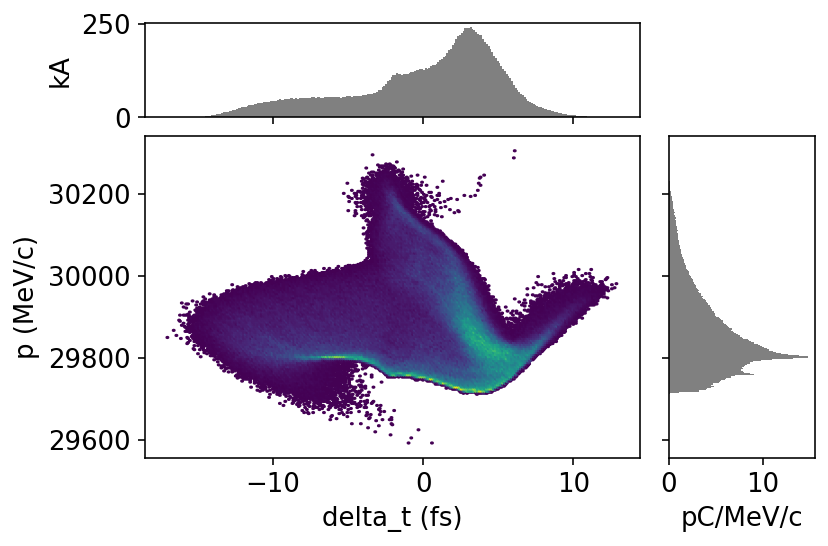

In [34]:
ooo['Pout'].plot('delta_t', 'p', bins=250)

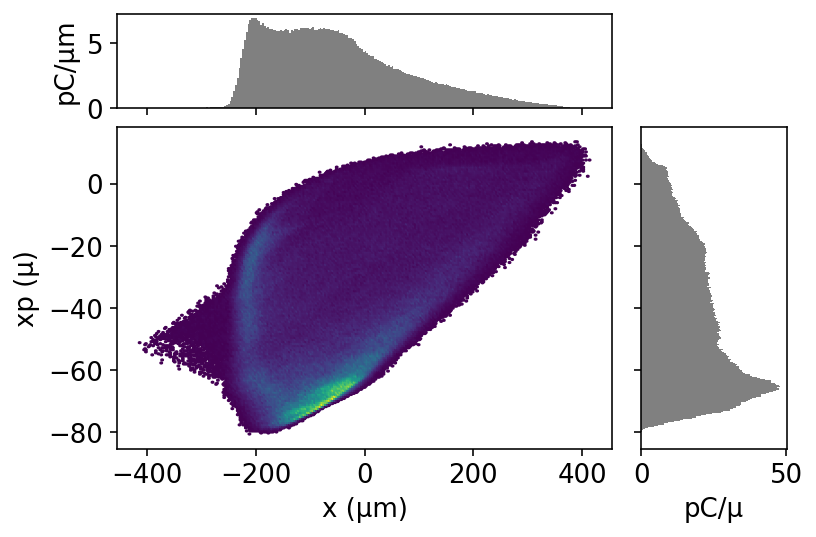

In [35]:
ooo['Pout'].plot('x', 'xp', bins=250)

In [15]:
ooo['Plist'][-1].plot('delta_t', 'p', bins=250)

KeyError: 'Plist'

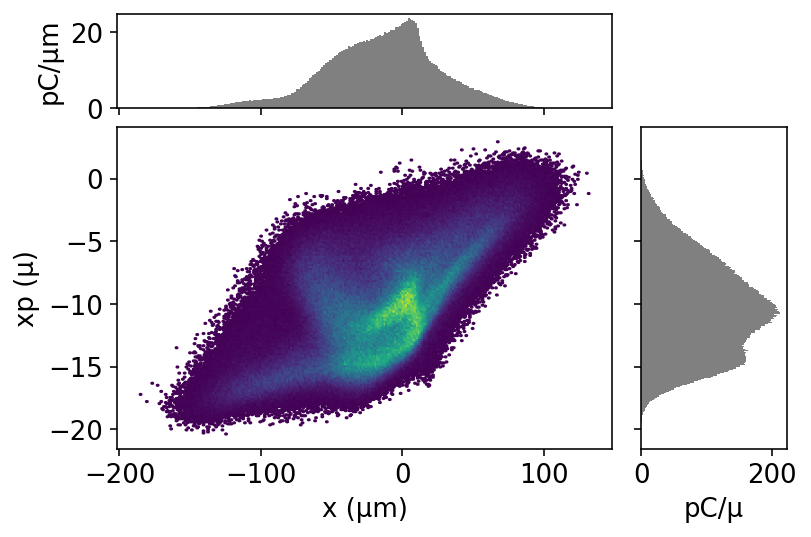

In [19]:
ooo['Plist'][-1].plot('x', 'xp', bins=250)

In [36]:
print(ooo['Pout']['sigma_t']*c_light *1e6)
print(ooo['Pout']['sigma_p']/p0c * 100)
print(ooo['Pout']['sigma_x']*1e3)
print(ooo['Pout'].twiss()['norm_emit_x'] *1e6)

1.513079200161834
0.3305147477047407
0.1302205217269003
89.81019599422444


In [20]:
ooo['Plist'][-1]['sigma_t']*c_light *1e6

0.604729364350181

In [21]:
ooo['Plist'][-1]['sigma_p']/p0c * 100

0.25657821646252477

In [22]:
ooo['Plist'][-1]['sigma_x']*1e3

0.04023831673111125

In [23]:
ooo['Plist'][-1].twiss()['norm_emit_x'] *1e6

6.80877354494631

# Intermiediate code deveps

In [6]:
with cf.ProcessPoolExecutor(max_workers=12) as executor:
    out1 = track_bend_with_2d_csr(P, p0c=p0c, gamma=gamma, L=20, g=1/rho, N_step=20, s0=0, nz=100, nx=100, 
                                     map_f=map, CSR_on = False, bend_name='CHICANE 1', debug=True)

In [114]:
out2 = track_drift_with_2d_csr(out1['Pout'], p0c=p0c, gamma=gamma, L=32.5, N_step=32, s0=20, drift_name ='D1', debug=True)

In [115]:
with cf.ProcessPoolExecutor(max_workers=12) as executor:
    out3 = track_bend_with_2d_csr(out2['Pout'], p0c=p0c, gamma=gamma, L=20, g=-1/rho, N_step=20, s0=52.5, nz=100, nx=100, 
                                     map_f=map, CSR_on = False, bend_name='CHICANE 2', debug=True)

In [118]:
out4 = track_drift_with_2d_csr(out3['Pout'], p0c=p0c, gamma=gamma, L=32.5, N_step=32, s0=72.5, drift_name ='D2', debug=True)

In [131]:
with cf.ProcessPoolExecutor(max_workers=12) as executor:
    out5 = track_bend_with_2d_csr(out4['Pout'], p0c=p0c, gamma=gamma, L=20, g=-1/rho, N_step=20, s0=105, nz=100, nx=100, 
                                     map_f=map, CSR_on = False, bend_name='CHICANE 3', debug=True)

In [132]:
out6 = track_drift_with_2d_csr(out5['Pout'], p0c=p0c, gamma=gamma, L=32.5, N_step=32, s0=125, drift_name ='D3', debug=True)

In [146]:
with cf.ProcessPoolExecutor(max_workers=12) as executor:
    out7 = track_bend_with_2d_csr(out6['Pout'], p0c=p0c, gamma=gamma, L=20, g=1/rho, N_step=20, s0=157.5, nz=100, nx=100, 
                                     map_f=map, CSR_on = False, bend_name='CHICANE 4', debug=True)

In [147]:
slist = out1['slist'] + out2['slist'][1:] + out3['slist'][1:] + out4['slist'][1:] + out5['slist'][1:] + out6['slist'][1:] + out7['slist'][1:] 

In [148]:
Plist = out1['Plist'] + out2['Plist'][1:] + out3['Plist'][1:] + out4['Plist'][1:] + out5['Plist'][1:] + out6['Plist'][1:] + out7['Plist'][1:]

In [138]:
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]

beta_x_list = [P.twiss()['beta_x'] for P in Plist]
alpha_x_list = [P.twiss()['alpha_x'] for P in Plist]
eta_x_list = [P.twiss()['eta_x'] for P in Plist]
beamsize_x_list = [P['sigma_x'] for P in Plist]
sigma_p_list = [P['sigma_p'] for P in Plist]
sigma_t_list = [P['sigma_t'] for P in Plist]

In [ ]:
plt.plot(slist, beamsize_x_list, label = 'python',color='b')
#plt.scatter(slist, tao_beamsize_x_list, label = 'bmad (1D CSR)',color='r',marker = '.')
#plt.scatter(slist, eleg_beamsize_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('beamsize_x (m)', fontsize=16)
plt.title('Horizontal beamsize\n comparison (CSR off)', fontsize=20)
plt.legend()

# Testing using Gaussian beam

In [30]:
gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34  # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Q = e_charge * 6.25e9


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
P0c = gamma * beta * mc2  # in eV

In [31]:
# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

# Check beam optics
P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
P.twiss()

{'alpha_x': 0.07140731799734733,
 'beta_x': 5.231423558032416,
 'gamma_x': 0.19212724680270407,
 'emit_x': 1.0187762035464371e-10,
 'eta_x': 0.012093798967067172,
 'etap_x': -0.04838054983616345,
 'norm_emit_x': 9.988082420656697e-07}

In [ ]:
#with cf.ProcessPoolExecutor(max_workers=12) as executor:
#    ttt = track_bend_with_2d_csr(P, p0c=P0c, gamma=gamma, L=0.5, g=1/rho, ds_step=0.01, s0=0, nz=200, nx=200, 
#                                     map_f=executor.map, CSR_on = True, xp_kick_on=False, debug=True)

In [36]:
Plist = ttt['Plist']
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]

# Main Loop

In [10]:
# Main switch
CSRon = True

In [23]:
# save the initial status

Plist = []       # To save the beam at each step
all_output = []  # To save the wake and grid at each step
slist = [0]      # To save the s position at each step
s = 0

##P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
Plist.append(P)


ds = 0.01

for i in range(1):
    print('Tracking through CHICANE 1 in the', i+1 , "th loop starting at s=" , s,'m' ) 

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)

    
    ## Calculate CSR kicks to xp and delta
    ####===================================
    
    if (CSRon):
        
        with cf.ProcessPoolExecutor(max_workers=12) as executor:
            output = csr2d_kick_calc(beam[4,:], beam[0,:], charges, gamma = 10000, rho = rho, nz=500, nx=500, 
                                     map_f = executor.map,
                                     debug=True)
        delta_kick = output['ddelta_ds'] 
        xp_kick = output['dxp_ds'] 
        

        #output = calc_csr_kick(beam, charges, Np=Np, gamma = 10000, rho = rho, Nz=100, sigma_z=sigma_z, Nx=100, sigma_x=sigma_x, verbose=True)
        all_output.append(output)

        #delta_kick = output['delta_kick'] 
        ###print('Typical delta:', np.mean(np.abs(beam[5])))
        ###print('Applied typical kick:', np.mean(np.abs(delta_kick)))    
        beam[5] = beam[5] + delta_kick * ds
    
        #xp_kick = output['xp_kick'] 
        beam[1] = beam[1] + xp_kick * ds
    
    ####====================================

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)
    
    # save the beam
    P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
    Plist.append(P)
    
    # save the s
    s += ds
    slist.append(s)
    

Tracking through CHICANE 1 in the 1 th loop starting at s= 0 m
Depositing particles takes: 0.01654362678527832 s
Computing potential grids take: 1.4544007778167725 s
Convolution takes: 0.412961483001709 s


In [39]:
from scipy.interpolate import RectBivariateSpline
zvec = output['zvec']
xvec = output['xvec']
Ws_grid = output['Ws_grid']

In [40]:
Ws_interp = RectBivariateSpline(zvec, xvec, Ws_grid)

In [60]:
zv = np.linspace(-1e-3,1e-3,1000)

In [ ]:
#=========== Tracking through D1 =================
LD = 32.5   # Langth of the drift
ds = LD

print('Tracking through drfit D1 in the', i+1 , "th loop starting at s=" , s,'m' ) 
beam = track_a_bend(beam, P0c = P0c, L=LD, theta = LD/rho, g_err=0)

P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
Plist.append(P)
    
# save the s
s += ds
slist.append(s)

In [75]:
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]

In [12]:
beta_x_list = [P.twiss()['beta_x'] for P in Plist]
alpha_x_list = [P.twiss()['alpha_x'] for P in Plist]
eta_x_list = [P.twiss()['eta_x'] for P in Plist]
beamsize_x_list = [P['sigma_x'] for P in Plist]
sigma_p_list = [P['sigma_p'] for P in Plist]

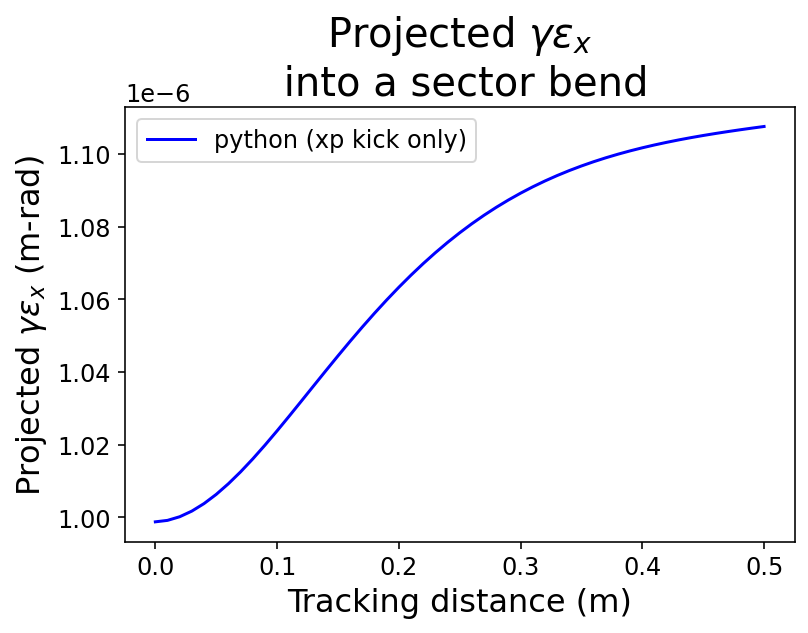

In [76]:
plt.plot(slist, pro_emit_x_list, label = 'python (xp kick only)',color = 'b');

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$ \n into a sector bend', fontsize=20)
plt.legend()

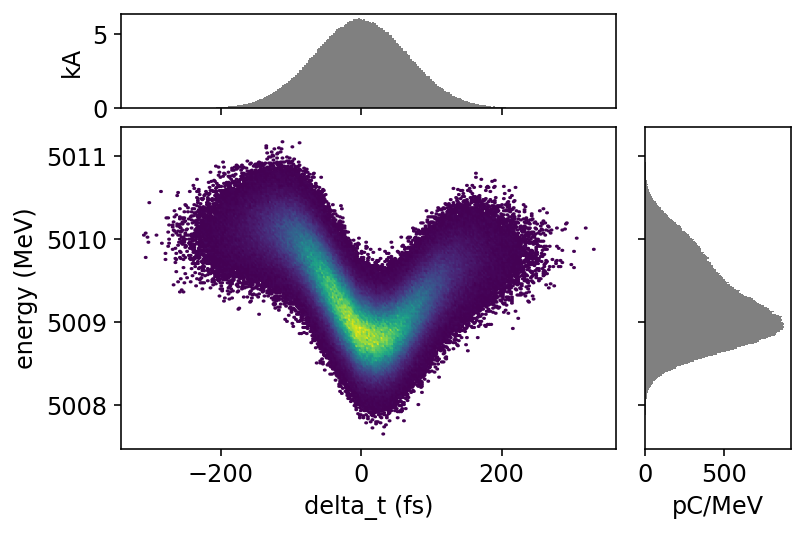

In [80]:
Plist[-1].plot('delta_t', 'energy', bins=250)

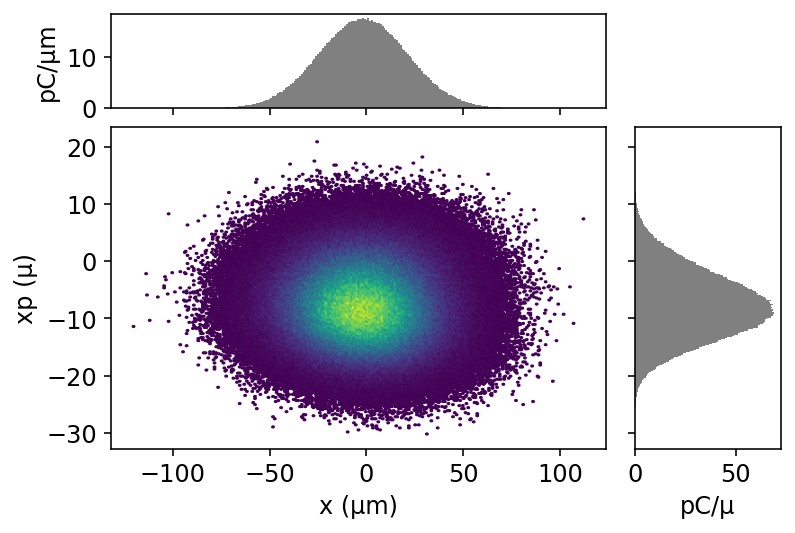

In [81]:
Plist[-1].plot('x', 'xp', bins=250)

## Import Tao results 

In [19]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File

#filename = './bmad/beam_dump_csroff_Np1M.h5'
filename = './bmad/beam_dump_csron_Np1M_Nb200.h5'
with File(filename, 'r') as h5:
    ppaths = particle_paths(h5)
    PG = [ParticleGroup(h5[g]) for g in ppaths]
    
def get_stat(key):
    return [P[key] for P in PG]

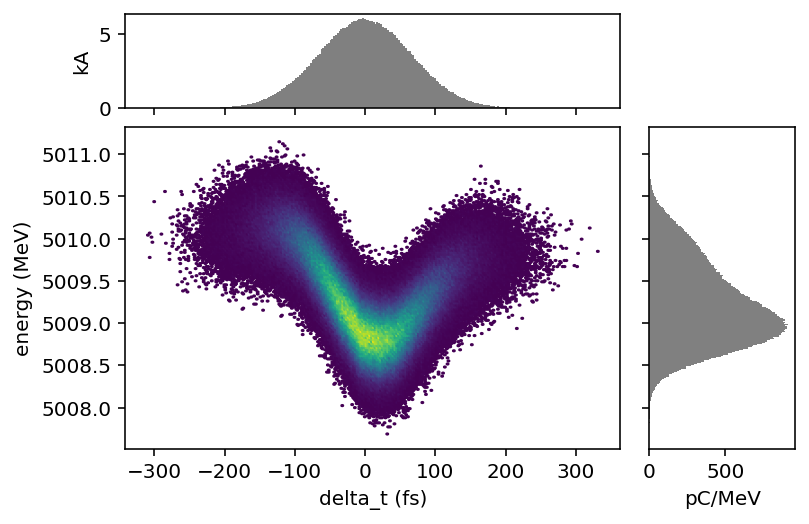

In [14]:
PG[-1].plot('delta_t', 'energy', bins=250)

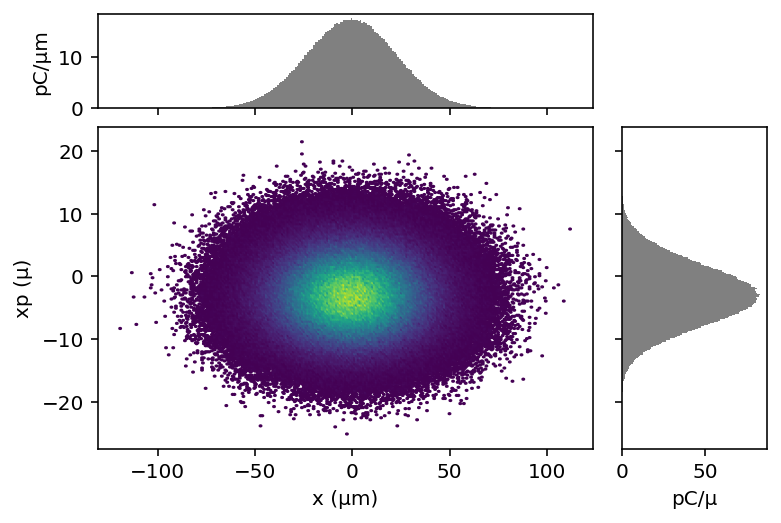

In [15]:
PG[-1].plot('x', 'xp', bins=250)

In [20]:
tao_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PG]

In [21]:
tao_beta_x_list = [P.twiss()['beta_x'] for P in PG]
tao_alpha_x_list = [P.twiss()['alpha_x'] for P in PG]
tao_eta_x_list = [P.twiss()['eta_x'] for P in PG]
tao_beamsize_x_list = [P['sigma_x'] for P in PG]
tao_sigma_p_list = [P['sigma_p'] for P in PG]

## Import Elegant results

In [15]:
from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

In [19]:
# OBSOLETE
# This cell can be slow since converting sdds files to h5 files takes time

locationList = ['M0',\
                'M1','M2','M3','M4','M5','M6','M7','M8','M9','M10',\
               'M11','M12','M13','M14','M15','M16','M17','M18','M19','M20',\
               'M21','M22','M23','M24','M25','M26','M27','M28','M29','M30',\
               'M31','M32','M33','M34','M35','M36','M37','M38','M39','M40',\
               'M41','M42','M43','M44','M45','M46','M47','M48','M49','M50']

def elegant_beam(location):
    beam_dir = '/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_Nb1000/'
    OUTFILE= beam_dir + locationList[location-1]+'.out'
    print('Filename: ' + OUTFILE)
    DAT = elegant_to_data(OUTFILE, charge = 1.0013603962588557E-09)
    P1 = ParticleGroup(data=DAT)
    Palive = P1.where(P1['status'] == 1)
    return Palive

#PE = [elegant_beam(i) for i in range(1,51)]

In [16]:
# CSR on
#PE = [ParticleGroup(f'/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_Nb1000/M{i}.out.h5') for i in range(0,51)]
PE = [ParticleGroup(f'./elegant/results_Np1M_Nb1000/M{i}.out.h5') for i in range(0,51)]

In [128]:
# CSR off
#PE = [ParticleGroup(f'/global/homes/w/wlou1991/CSR2D/elegant/results_Np1M_csroff/M{i}.out.h5') for i in range(0,51)]
PE = [ParticleGroup(f'./elegant/results_Np1M_csroff/M{i}.out.h5') for i in range(0,51)]

In [17]:
eleg_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PE]

In [18]:
eleg_beta_x_list = [P.twiss()['beta_x'] for P in PE]
eleg_alpha_x_list = [P.twiss()['alpha_x'] for P in PE]
eleg_eta_x_list = [P.twiss()['eta_x'] for P in PE]
eleg_beamsize_x_list = [P['sigma_x'] for P in PE]
eleg_sigma_p_list = [P['sigma_p'] for P in PE]

# Load Glen's Matlab result

In [114]:
#matlab_pro_emit_x_list = np.loadtxt('Glen_matlab_results/emit_2a_ss.txt')[1]
#matlab_pro_emit_x_list = np.loadtxt('Glen_matlab_results/emit_2a_ss.txt')[51:102]
#len(matlab_pro_emit_x_list)

In [25]:
def glen_to_bmad(glen_beam, p0c):
    beam = glen_beam.T
    beam[4] = -beam[4]   #flip z
    beam[5] = (beam[5]*1e9-p0c)/p0c
    return beam

In [22]:
#matlab_beam_nocsr = np.loadtxt('Glen_matlab_results/X_nocsr.txt')
#matlab_beam_nocsr = np.loadtxt('Glen_matlab_results/X2_ess.txt')
#matlab_beam_nocsr = np.loadtxt('Glen_matlab_results/X2_xss.txt')
matlab_beam_nocsr = np.loadtxt('Glen_matlab_results/X2_ss.txt')

In [23]:
p0c

29999999995.648003

In [26]:
bb = glen_to_bmad(matlab_beam_nocsr, p0c)

In [27]:
P_glen = bmad_to_particle_group(bb, p0c = p0c, t_ref = 0, charges = charges, verbose=False)

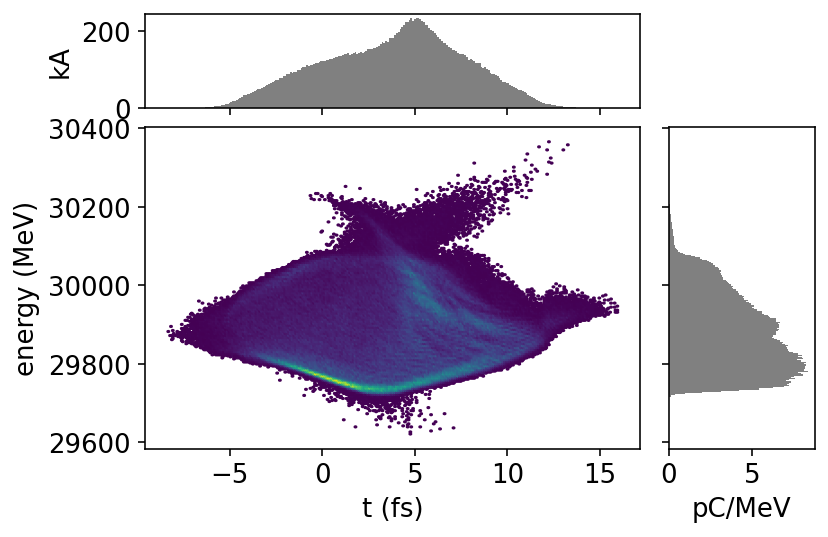

In [28]:
P_glen.plot('t', 'energy', bins=250)

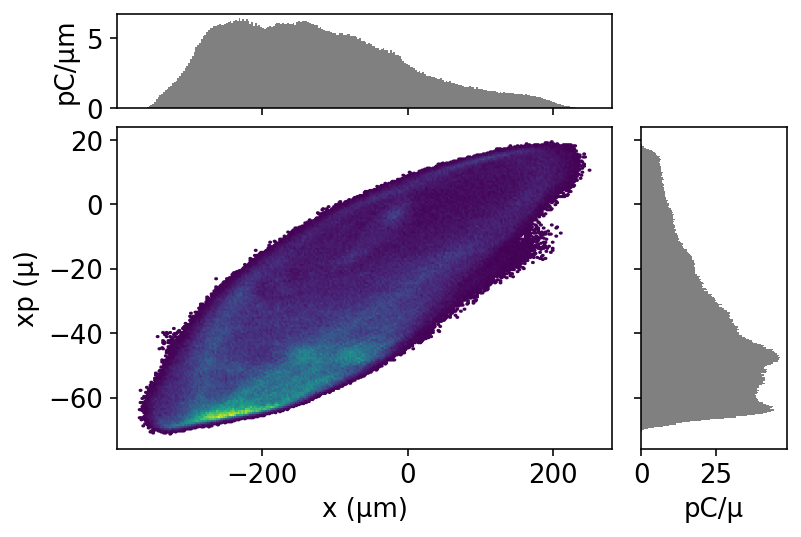

In [29]:
P_glen.plot('x', 'xp', bins=250)

In [30]:
P_glen['sigma_t']* c_light *1e6

1.1408452171520345

In [31]:
P_glen['sigma_p']/p0c * 100

0.3182627299056962

In [32]:
P_glen['sigma_x'] *1e3

0.12153446191882858

In [33]:
P_glen.twiss()['norm_emit_x'] *1e6

56.033506965026895

# Plotting

## CSR on plots

In [38]:
font = {'weight' : 'medium',
        'size'   : 12}

matplotlib.rc('font', **font)

In [46]:
offset = pro_emit_x_list[0]-matlab_pro_emit_x_list[0]

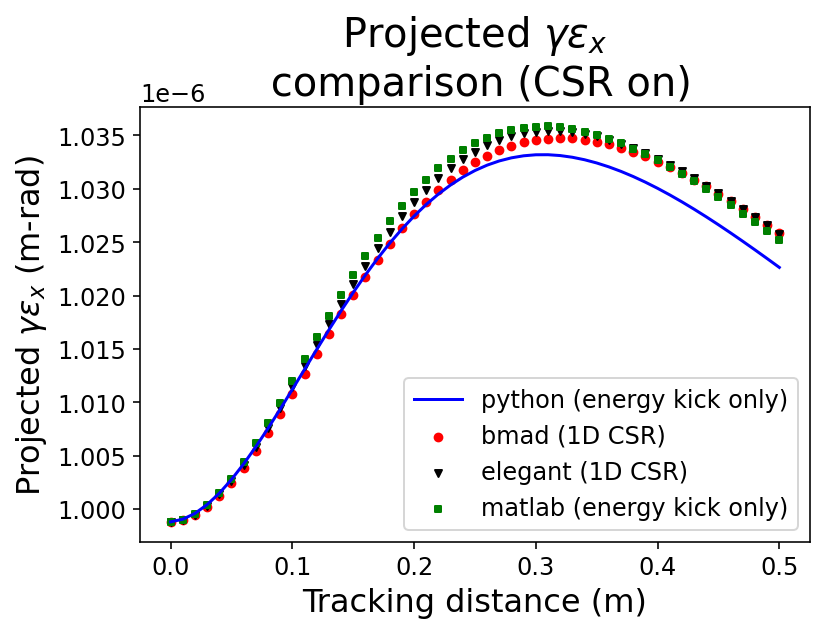

In [47]:
plt.plot(slist, pro_emit_x_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_pro_emit_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_pro_emit_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)
plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (energy kick only)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend()

In [35]:
offset = pro_emit_x_list[0]-matlab_pro_emit_x_list[0]

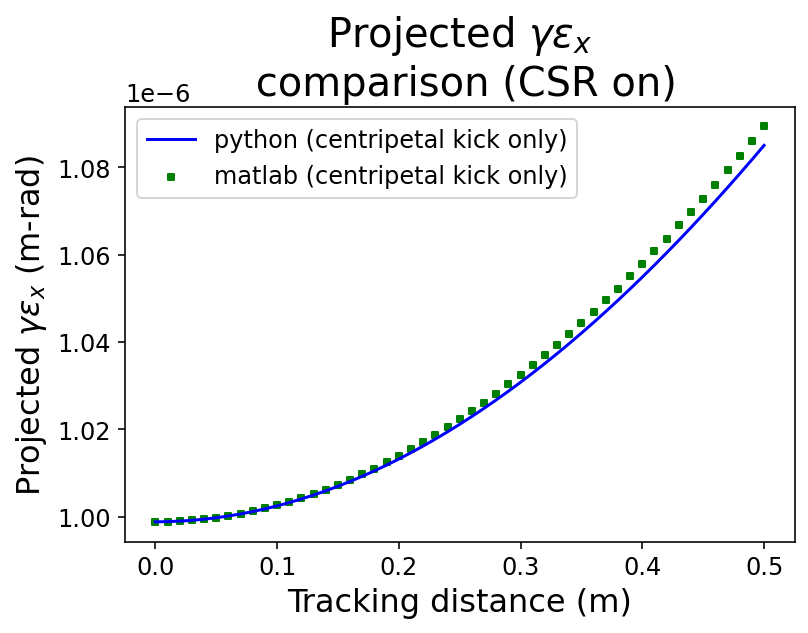

In [39]:
plt.plot(slist, pro_emit_x_list, label = 'python (centripetal kick only)',color='b')

plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (centripetal kick only)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend()

In [95]:
offset = pro_emit_x_list[0]-matlab_pro_emit_x_list[0]

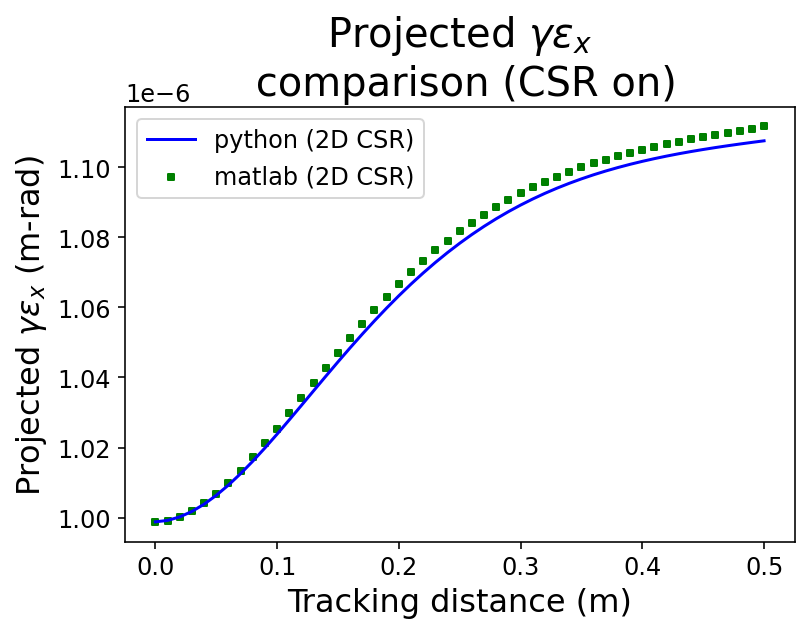

In [96]:
plt.plot(slist, pro_emit_x_list, label = 'python (2D CSR)',color='b')

plt.scatter(slist,matlab_pro_emit_x_list + offset, label = 'matlab (2D CSR)',color='g', marker ='s', s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR on)',  fontsize=20)
plt.legend()

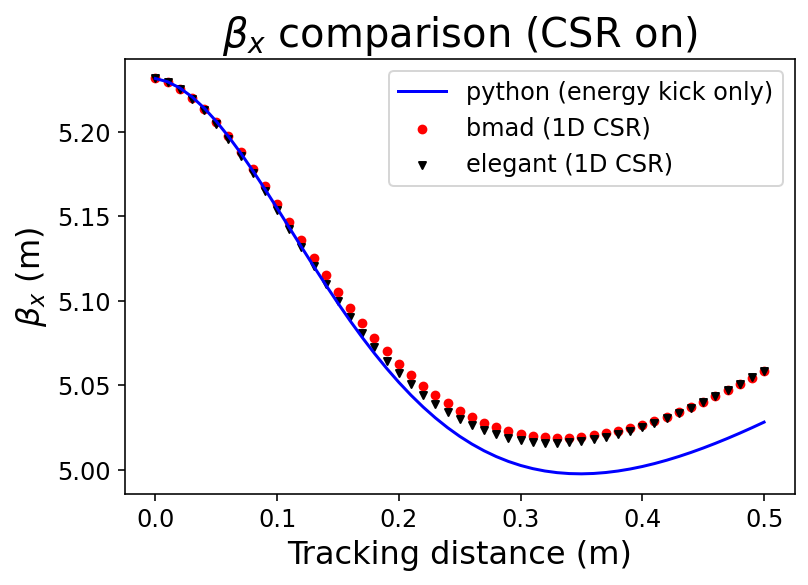

In [105]:
plt.plot(slist, beta_x_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_beta_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_beta_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\beta_x$ (m)', fontsize=16)
plt.title(r'$\beta_x$ comparison (CSR on)', fontsize=20)
plt.legend()

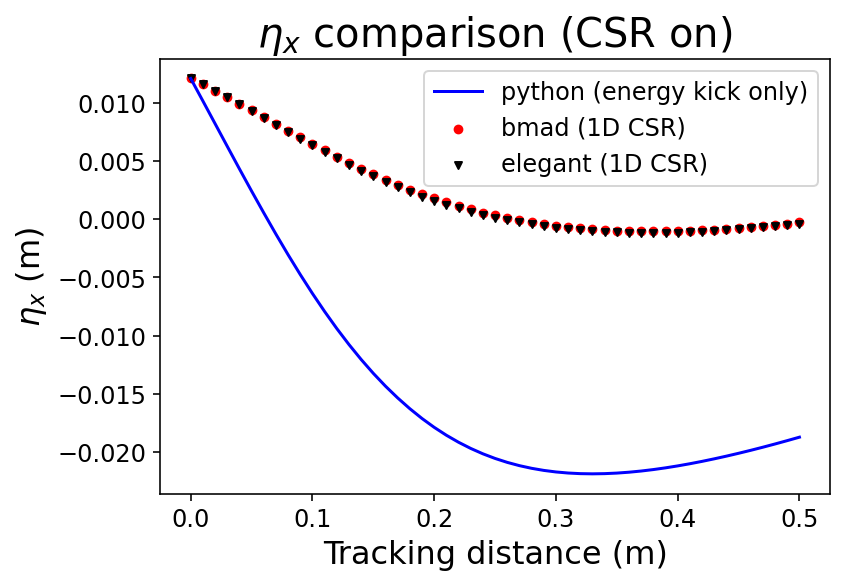

In [92]:
plt.plot(slist, eta_x_list, label = 'python (energy kick only)', color='b')
plt.scatter(slist, tao_eta_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_eta_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\eta_x$ (m)', fontsize=16)
plt.title(r'$\eta_x$ comparison (CSR on)', fontsize=20)
plt.legend()

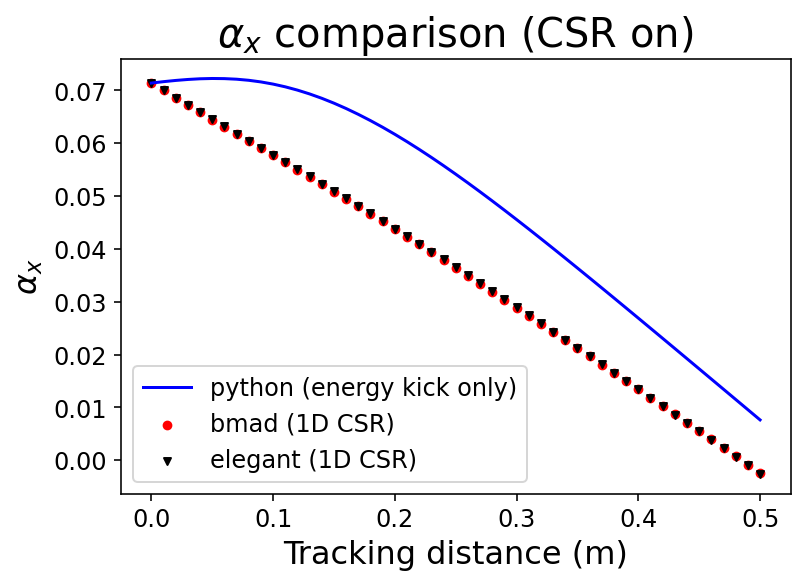

In [95]:
plt.plot(slist, alpha_x_list, label = 'python (energy kick only)', color='b')
plt.scatter(slist, tao_alpha_x_list, label = 'bmad (1D CSR)',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_alpha_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\alpha_x$', fontsize=16)
plt.title(r'$\alpha_x$ comparison (CSR on)', fontsize=20)
plt.legend()

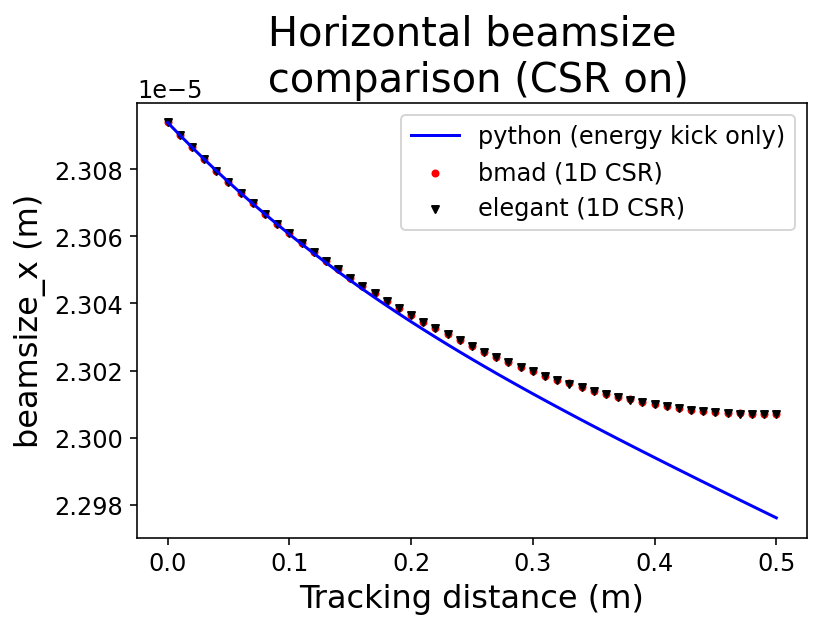

In [97]:
plt.plot(slist, beamsize_x_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_beamsize_x_list, label = 'bmad (1D CSR)',color='r',marker = '.')
plt.scatter(slist, eleg_beamsize_x_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('beamsize_x (m)', fontsize=16)
plt.title('Horizontal beamsize\n comparison (CSR on)', fontsize=20)
plt.legend()

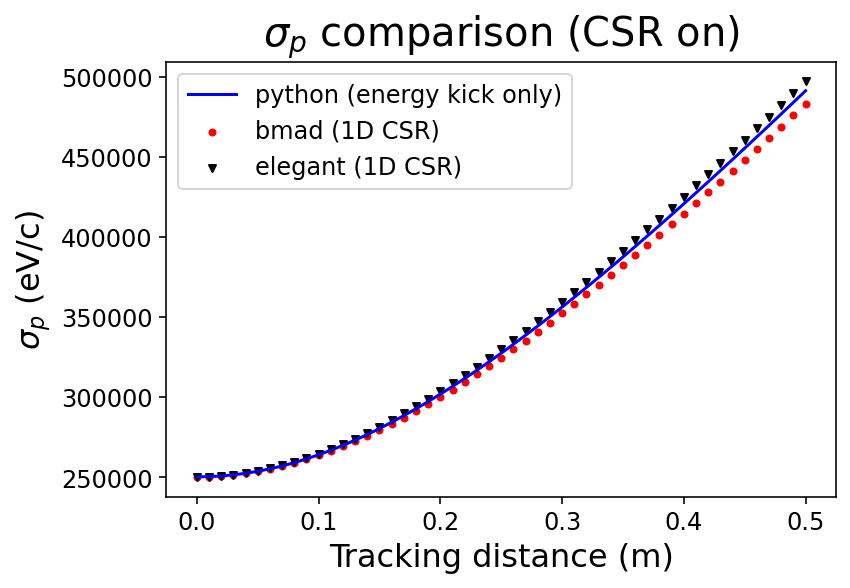

In [107]:
plt.plot(slist, sigma_p_list, label = 'python (energy kick only)',color='b')
plt.scatter(slist, tao_sigma_p_list, label = 'bmad (1D CSR)',color='r',marker = '.')
plt.scatter(slist, eleg_sigma_p_list, label = 'elegant (1D CSR)',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel(r'$\sigma_{p}$ (eV/c)', fontsize=16)
plt.title(r'$\sigma_{p}$ comparison (CSR on)', fontsize=20)
plt.legend()

## CSR off plots

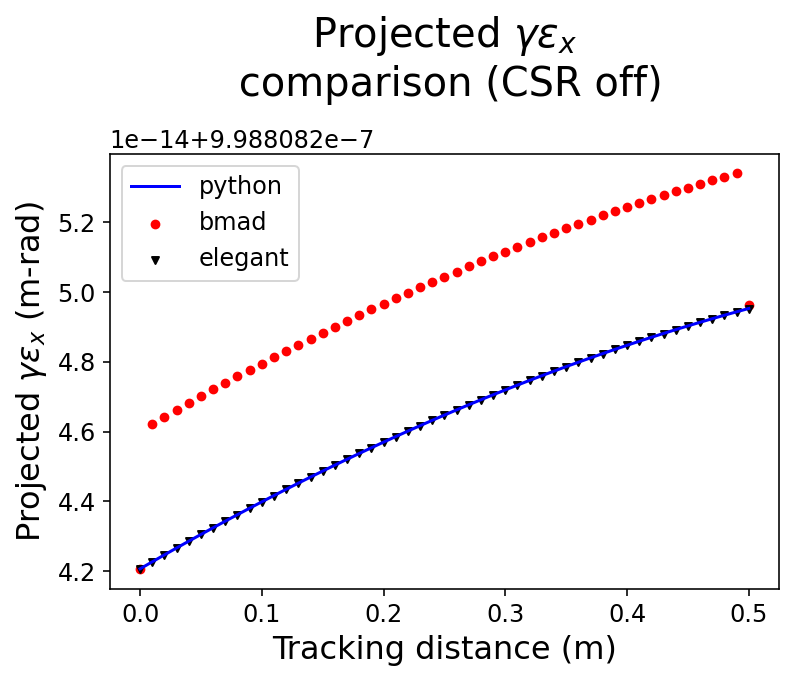

In [148]:
plt.plot(slist, pro_emit_x_list, label = 'python',color='b')
plt.scatter(slist, tao_pro_emit_x_list, label = 'bmad',color='r',marker = '.',s=60)
plt.scatter(slist, eleg_pro_emit_x_list, label = 'elegant',color = 'black',marker = 'v',s=12)

plt.xlabel('Tracking distance (m)', fontsize=16)
plt.ylabel('Projected $\gamma\epsilon_{x}$ (m-rad)', fontsize=16)
plt.title('Projected $\gamma\epsilon_{x}$\n comparison (CSR off)\n',  fontsize=20)
plt.legend()

### Phase space plots

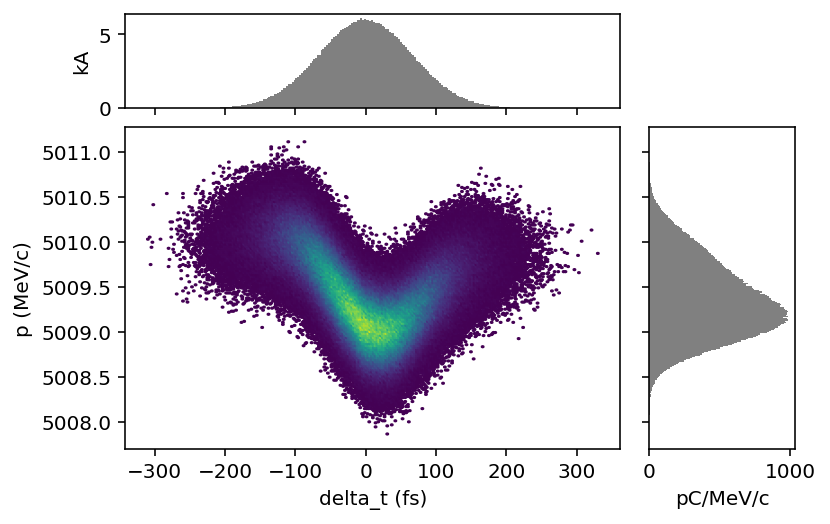

In [110]:
Plist[40].plot('delta_t', 'p', bins=250)

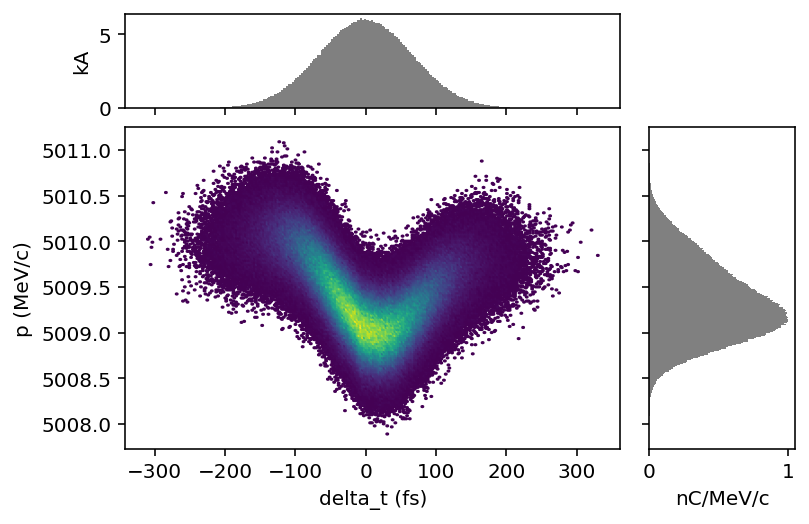

In [111]:
PG[40].plot('delta_t', 'p', bins=250)

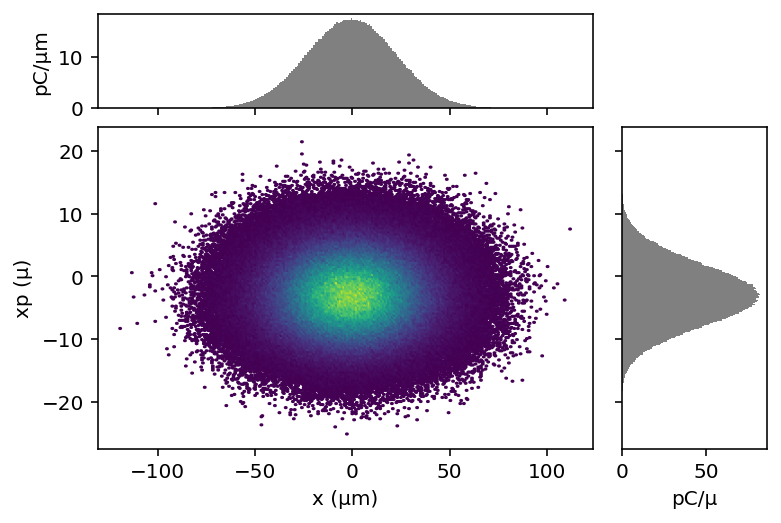

In [117]:
PE[50].plot('x', 'xp', bins=250)

## Save files

In [162]:
np.savetxt('slist.txt', slist)

In [168]:
out8['Pout']

<ParticleGroup with 1000000 particles at 0x2aaaeb8aeb50>

In [28]:
np.savetxt('pro_emit_x_list.txt', pro_emit_x_list)
np.savetxt('beta_x_list.txt', beta_x_list)
#np.savetxt('alpha_x_list.txt', alpha_x_list)
np.savetxt('eta_x_list.txt', eta_x_list)
np.savetxt('beamsize_x_list.txt', beamsize_x_list)
np.savetxt('sigma_z_list.txt', sigma_z_list)
np.savetxt('sigma_p_list.txt', sigma_p_list)

In [31]:
hehe =  ooo['Plist'][-1]
hehe

<ParticleGroup with 1000000 particles at 0x2aaaf3a22430>

In [32]:
np.save('Pout.dat', hehe, allow_pickle=True)

KeyboardInterrupt: 

In [148]:
np.savetxt('tao_pro_emit_x_list.txt', tao_pro_emit_x_list)
np.savetxt('tao_beta_x_list.txt', tao_beta_x_list)
np.savetxt('tao_alpha_x_list.txt', tao_alpha_x_list)
np.savetxt('tao_eta_x_list.txt', tao_eta_x_list)
np.savetxt('tao_beamsize_x_list.txt', tao_beamsize_x_list)

In [149]:
np.savetxt('eleg_pro_emit_x_list.txt', eleg_pro_emit_x_list)
np.savetxt('eleg_beta_x_list.txt', eleg_beta_x_list)
np.savetxt('eleg_alpha_x_list.txt', eleg_alpha_x_list)
np.savetxt('eleg_eta_x_list.txt', eleg_eta_x_list)
np.savetxt('eleg_beamsize_x_list.txt', eleg_beamsize_x_list)

## Check emittance

In [95]:
temp = np.array([all_output[i]['Ws_grid'] for i in range(len(all_output))])
np.save('Ws_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [96]:
temp = np.array([all_output[i]['Wx_grid'] for i in range(len(all_output))])
np.save( 'Wx_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [97]:
temp = np.array([all_output[i]['zvec'] for i in range(len(all_output))])
np.save( 'zvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [98]:
temp = np.array([all_output[i]['xvec'] for i in range(len(all_output))])
np.save( 'xvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [99]:
np.save( 'slist_0.5m_50steps.npy', slist, allow_pickle=True)

In [4]:
def projected_emit_x(beam):
    SS = np.cov(beam)
    s00 = SS[0][0] - SS[0][5]*SS[0][5] / SS[5][5]
    s01 = SS[0][1] - SS[0][5]*SS[1][5] / SS[5][5]
    s11 = SS[1][1] - SS[1][5]*SS[1][5] / SS[5][5]

    return np.sqrt(s00*s11 - s01**2)

In [5]:
print(emit_x)          # desired
projected_emit_x(beam) # from the beam

1.0199918400652795e-10


1.0187762619965156e-10